In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import davies_bouldin_score
from numba import jit
plt.style.use('seaborn')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

In [22]:
# -------- Density Peak Clustering --------
class DPC():
    """
    dis: 二维数组,两点之间的欧氏距离
    rho: 一维数组,局部密度。可选截断核(cut_off)或高斯核(gauss)方式计算
    delta: 一维数组,基于密度的距离
    sorted_rho: 一维数组,局部密度降序排列对应下标
    center_index: 簇中心下标
    label: 分类标签
    """
    def pretreatment(self, df):
        return np.array( (df - df.min()) / (df.max() - df.min()) )
    
    def fit(self, x, d_c, kernal="cut_off"):
        self.dis, self.rho, self.delta, self.sorted_rho = self._fit(x, d_c, kernal)
        self.plot_decesion()
        
    @staticmethod
    @jit(nopython=True)
    def _fit(x, d_c, kernal):
        n = x.shape[0]
        dis, rho, delta = np.zeros((n,n)), np.zeros(n), np.zeros(n)        
        # 计算欧式距离与局部密度
        for i in range(n):
            for j in range(i+1,n):
                dis[i][j] = dis[j][i] = np.linalg.norm(x[i] - x[j])
            if kernal == "gauss":
                rho[i] = np.exp(-(dis[i]/d_c)**2).sum() - 1
            elif kernal == 'cut_off':
                for j in range(n):
                    rho[i] += 1 if dis[i][j]<d_c else 0
            else:
                print("This kernal method is not supported.")
                return               
        # 计算基于密度的距离
        index = np.argsort(-rho)
        delta[index[0]] = dis[index[0]].max()
        for i in range(1,n):
            delta[index[i]] = dis[index[i]][index[0:i]].min()
        return dis, rho, delta, index
        
    def predict(self, x, rho_value, delta_value):
        n = x.shape[0]
        self.label = np.zeros(n)
        self.center_index=[]
        
        j = 1   
        for i in range(n):
            # Cluster centers
            if self.rho[i] >= rho_value and self.delta[i] >= delta_value:
                self.center_index.append(i)
                self.label[i] = j
                j += 1
            # OOD points
            elif self.rho[i] < rho_value and  self.delta[i] >= delta_value:
                self.label[i] = -1

        # Remaining points         
        index = self.sorted_rho
        for i in range(n):
            if self.label[index[i]] == 0:
                j = np.argmin(self.dis[index[i]][index[:i]])
                self.label[index[i]] = self.label[index[j]]
                
        
    def plot_decesion(self):
        trace0 = go.Scatter(x=self.rho, y=self.delta, mode='markers', marker_size = 6)
        layout = go.Layout(title='决策图', xaxis_title="ρ", yaxis_title="δ",width=600,height=600,template="plotly")
        data = [trace0]
        fig = go.Figure(data, layout)
        plotly.offline.iplot(fig)
        
    def plot_result(self, X):
        plt.figure(figsize=(10,6), dpi=80)
        plt.scatter(x=X[:,0], y=X[:,1], c=self.label, s=70, cmap='tab20',alpha=0.5)
        plt.scatter(x=X[self.center_index][:,0], y=X[self.center_index][:,1], marker="x", s=100,c="r")
        plt.xlabel("f1", fontsize=13)
        plt.ylabel("f2", fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.title('聚类结果', fontsize=15)
        plt.show()
        

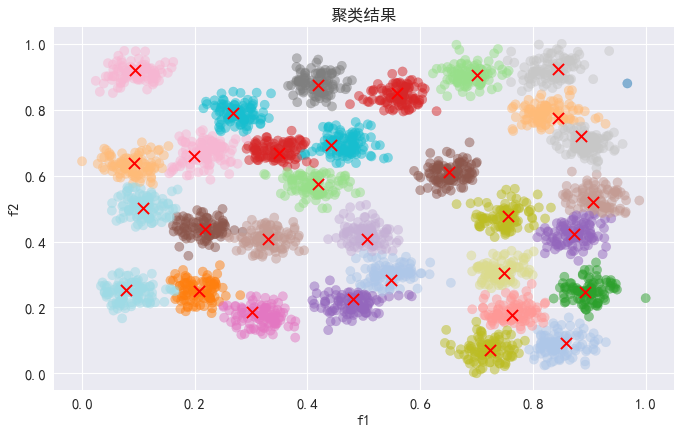

0.5456326805854976

In [30]:
df=pd.read_csv("Datasets/D31.txt",sep=" ",header=None)

dpc = DPC()
data = dpc.pretreatment(df)
dpc.fit(data,d_c=0.06)
dpc.predict(data,rho_value=84,delta_value=0.06) # for D31 dc=0.06
dpc.plot_result(data)
davies_bouldin_score(df, dpc.label)

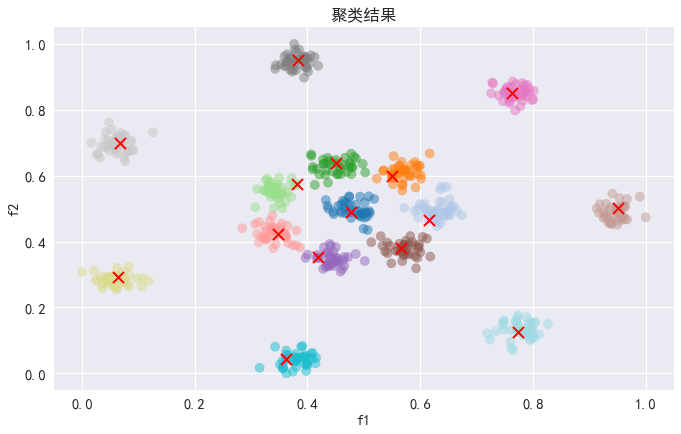

0.31481596929442923

In [26]:
df=pd.read_csv("Datasets/R15.txt",sep=" ",header=None)
dpc = DPC()
data = dpc.pretreatment(df)
dpc.fit(data,d_c=0.06)
dpc.predict(data,rho_value=37,delta_value=0.08) # for R15 dc=0.06
dpc.plot_result(data)
davies_bouldin_score(df, dpc.label)

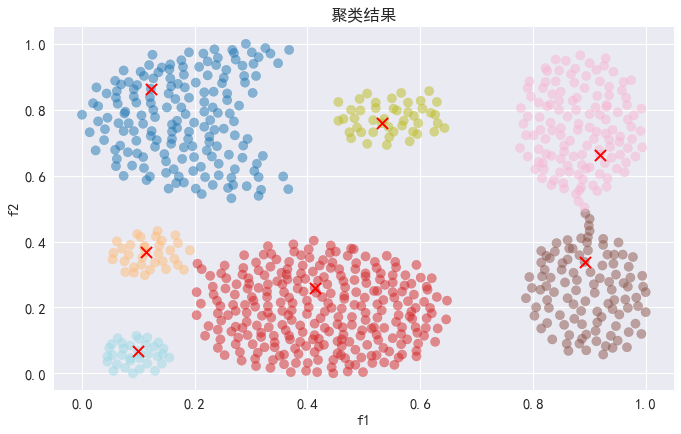

0.5037235117749277

In [24]:
df=pd.read_csv("Datasets/Aggregation.txt",sep=" ",header=None)
dpc = DPC()
data = dpc.pretreatment(df)
dpc.fit(data,d_c=0.075)
dpc.predict(data,rho_value=29,delta_value=0.20) # for Aggregation dc=0.075
dpc.plot_result(data)
davies_bouldin_score(df, dpc.label)

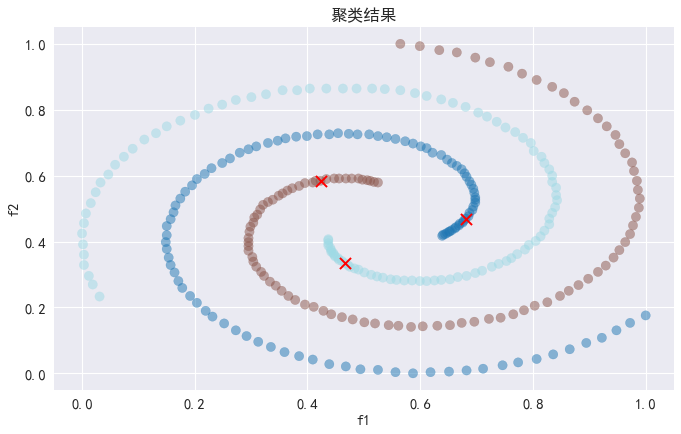

5.882022552277642

In [27]:
df=pd.read_csv("Datasets/spiral.txt",sep=" ",header=None)
dpc = DPC()
data = dpc.pretreatment(df)
dpc.fit(data,d_c=0.1,kernal='gauss')
dpc.predict(data,rho_value=16,delta_value=0.19) # for spiral dc=0.1 with gauss kernel
dpc.plot_result(data)
davies_bouldin_score(df, dpc.label)

In [78]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

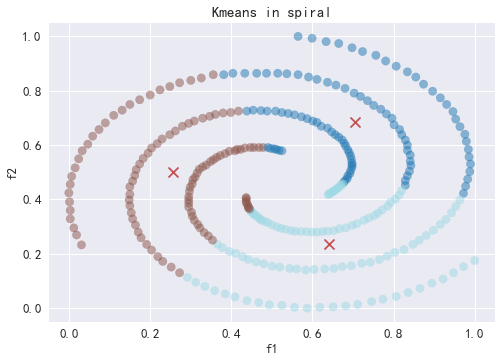

0.8816755216669746

In [79]:
kmeans = KMeans(n_clusters=3).fit(data)
plt.scatter(x=data[:,0], y=data[:,1], c=kmeans.labels_, s=70, cmap='tab20',alpha=0.5)
plt.scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], marker="x", s=100,c="r")
plt.xlabel("f1", fontsize=13)
plt.ylabel("f2", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Kmeans in spiral', fontsize=15)
plt.show()
davies_bouldin_score(data, kmeans.labels_)

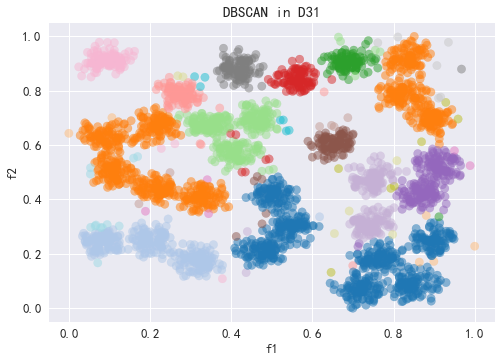

1.0292689063898048

In [161]:
dbscan = DBSCAN(eps=0.02, min_samples=1).fit(data)
plt.scatter(x=data[:,0], y=data[:,1], c=dbscan.labels_, s=70, cmap='tab20',alpha=0.5)
plt.xlabel("f1", fontsize=13)
plt.ylabel("f2", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('DBSCAN in D31', fontsize=15)
plt.show()
davies_bouldin_score(data, dbscan.labels_)

0.8794822047212806

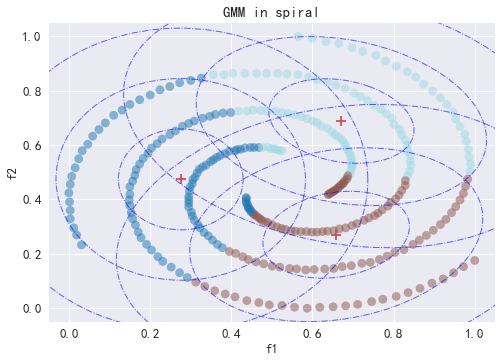

In [236]:
from sklearn.mixture import GaussianMixture
from PIL import Image
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()

    #将协方差转换为主轴
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    #画出椭圆
    for nsig in range(1, 4):
        ellipse = Ellipse(position, nsig * width, nsig * height,angle, **kwargs)
        ax.add_patch(ellipse)
        ellipse.set(fc='None',ls='-.',ec='blue',alpha=0.6,lw=1)
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=70, cmap='tab20',alpha=0.5)
    ax.scatter(gmm.means_[:,0],gmm.means_[:,1],s=100,marker='+',c='r')
    plt.xlabel("f1", fontsize=13)
    plt.ylabel("f2", fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title('GMM in spiral', fontsize=15)
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
gmm = GaussianMixture(n_components=3)
gmm.fit(data)
labels = gmm.predict(data)
plot_gmm(gmm,data)

davies_bouldin_score(data, labels)

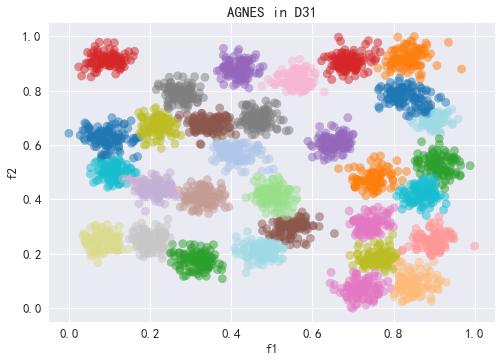

0.5565295633392521

In [32]:
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(n_clusters=31).fit(data)
plt.scatter(x=data[:,0], y=data[:,1], c=AC.labels_, s=70, cmap='tab20',alpha=0.5)
plt.xlabel("f1", fontsize=13)
plt.ylabel("f2", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('AGNES in D31', fontsize=15)
plt.show()
davies_bouldin_score(data, AC.labels_)